In [1]:
import numpy as np
import pickle
import math
import cmath
import scipy 
import scipy.linalg
import scipy.integrate
import sys
import tqdm
import warnings
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline

import MolmerSorensonLibrary


/Users/joseph/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
calculated_results_filestr = "calculated_results_file.pkl"

In [3]:
results_storage = {}

In [4]:
eta=0.1
energy_vibrational = .1

initial_number_vibrational_states = 12

rabi_energy = .10 * energy_vibrational 

laser_detuning_delta_energy = .90 * energy_vibrational
laser_energy_1 = laser_detuning_delta_energy
laser_energy_2 = -laser_detuning_delta_energy


c_0 = 1.0
c_1 = 0.0

num_expts = 30
c_2_values_temp = np.logspace(-3.5, -1, num_expts - 1)
c_2_values = np.zeros(num_expts)
c_2_values[0] = 0.0
c_2_values[1:] = c_2_values_temp

vibrational_frequency_cycles = 7000.0 / (2.0 * np.pi)#will multiply the frequency of the lowest frequency mode to get the max time


In [5]:
for c_2 in c_2_values:
    if c_2 in results_storage:
        print("c_2 = %f already calculated, moving along..." %c_2)
        continue
    c_list = [c_0 - c_2*(1 + 2*2), c_1, c_2]
    MS_system = MolmerSorensonLibrary.MolmerSorenson(
                    number_vibrational_states = initial_number_vibrational_states,
                    energy_vibrational = energy_vibrational, 
                    eta_values_list = [eta, eta], 
                    transition_dipole_c_values = c_list)
    
    barN_equals_2_CSgen = lambda : MS_system.coherent_vibrational_state_ground_electronic( math.sqrt(2))
    
    
    t, results = MS_system.propagate(laser_energy_list_of_lists=[[laser_energy_1, laser_energy_2], [laser_energy_1, laser_energy_2]], 
                                  rabi_energy_list_of_lists=[[rabi_energy, rabi_energy], [rabi_energy, rabi_energy]],
                                  initial_state_generator = barN_equals_2_CSgen,
                            max_time_vibrational_cycles =vibrational_frequency_cycles)
    results_storage[c_2] = MS_system
    #in case it got bigger...
    initial_number_vibrational_states = MS_system.number_vibrational_states

  0%|          | 209/250670 [00:00<02:00, 2085.00it/s]


Increasing Number of vibrational states to 13 
Time reached:35.4106280193
electronic quantum number0


100%|██████████| 250670/250670 [01:54<00:00, 2187.23it/s]


In [6]:
#Calculate Heating
heating_signals = []
for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]
    
    heating_trace = MS_system.average_vibrational_quanta()
    
    signal =  heating_trace
    heating_signals.append(signal)

0.0


MolmerSorensonLibrary.py:416: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.propagated_results == None:


0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


In [7]:
#Calculate Fidelity

fidelity_signals = []
gg_population_signals = []
ee_population_signals = []

for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    
    e_red_density_matrix = MS_system.reduced_electronic_density_matrix()
    gg_population_signals.append(e_red_density_matrix[:,0,0])
    ee_population_signals.append(e_red_density_matrix[:,-1,-1])
    rabi_energy_effective = MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    expected_density_matrix = MS_system.expected_unitary_dynamics(expected_rabi_energy = rabi_energy_effective,   
                                                            initial_density_matrix = e_red_density_matrix[0],
                                                            time_values = t)
    fidelity_time_trace = MS_system.fidelity(expected_density_matrix, e_red_density_matrix)
    
    signal =  fidelity_time_trace
    fidelity_signals.append(signal**2)



0.0


MolmerSorensonLibrary.py:396: ComplexWarning: Casting complex values to real discards the imaginary part
  new_fidelity = math.sqrt(self.trace(rho_product) + 2 * math.sqrt(rho_1_det * rho_2_det))


0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


In [73]:
epr_wf = np.zeros(4, dtype = np.complex)
epr_wf[0] = 1.0
epr_wf[3] = -1.0j
epr_wf = epr_wf / math.sqrt(2.0)
epr_wf_ct = np.conj(epr_wf.T)

epr_amplitude_signals = []
for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    
    e_red_density_matrix = MS_system.reduced_electronic_density_matrix()
    
    new_amplitude_series = []
    for index_t, rho_t in enumerate(e_red_density_matrix):
        epr_amp = np.dot(epr_wf_ct, np.dot(rho_t, epr_wf))
        new_amplitude_series.append(epr_amp)
    epr_amplitude_signals.append(np.array(new_amplitude_series))

0.0
0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


In [53]:
#Stuff for plotting
def moving_average( a, window_size) :
    output = np.convolve(a, np.ones((window_size,))/window_size, mode='valid')
    return output

colorMap_name = 'winter'
window_size = 5000
def find_inf(list_in, replacement):
    output = []
    for item in list_in:
        if np.isinf(item):
            item = replacement
        output.append(item)
    return output

scale = np.log10(c_2_values)
label_scale = find_inf(scale, r"$-\infty$")
colorbar_Scale = find_inf(scale, scale[1] - 1)

cNorm  = matplotlib.colors.Normalize(vmin=np.min(colorbar_Scale), vmax=np.max(colorbar_Scale))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap(colorMap_name))

Z = [[np.min(colorbar_Scale),0],[np.max(colorbar_Scale),0]]
CS3 = plt.contourf(Z, len(colorbar_Scale), cmap=plt.get_cmap(colorMap_name))
plt.clf()




/Users/joseph/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


0.0
0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


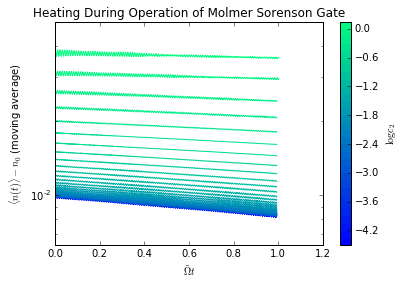

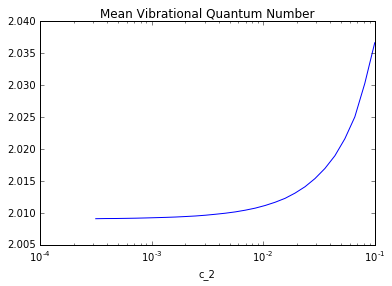

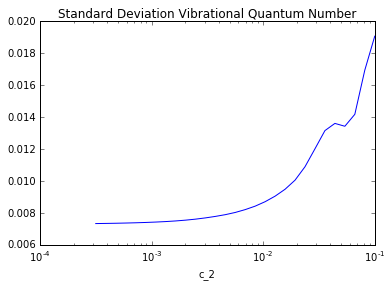

In [69]:
average_vibrational_quantum_number_list = []
stdev_quantum_number_Trace_list = []
for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    rabi_energy_effective = -MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    t_plot = t[0:-5*window_size+1] * 2 *rabi_energy_effective
    
    signal = heating_signals[i]
    signal_mean = np.average(signal)
    average_vibrational_quantum_number_list.append(signal_mean)
    
    signal_stdev = np.std(signal)
    stdev_quantum_number_Trace_list.append(signal_stdev)
    plot_signal = moving_average(signal, 5*window_size)

    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.semilogy(t_plot, plot_signal - 2, label=label_scale[i], color = colorVal)
# plt.legend(loc=0, fancybox=True,shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("Heating During Operation of Molmer Sorenson Gate")
plt.ylabel(r"$\langle n(t) \rangle - n_0$ (moving average)")
plt.xlabel(r"$ \tilde{\Omega} t $")
CB = plt.colorbar(CS3)
CB.ax.set_ylabel(r"$\log c_2$")
plt.ylim(10**-2.2,10**-1.3)
plt.savefig("MS_heating_cComparison.png")



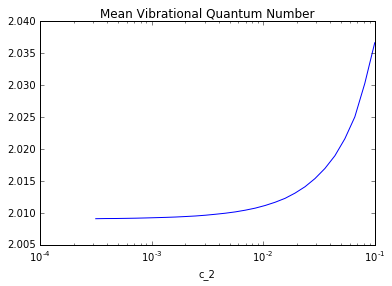

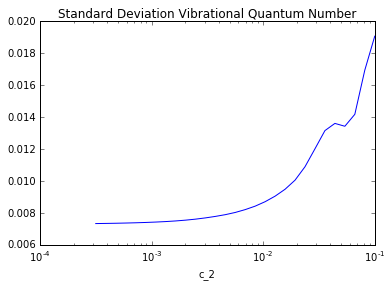

In [78]:
plt.figure()
plt.title("Mean Vibrational Quantum Number")
plt.semilogx(c_2_values, np.array(average_vibrational_quantum_number_list))
plt.xlabel("c_2")
plt.savefig("mean_heating.png")

plt.figure()
plt.title("Standard Deviation Vibrational Quantum Number")
plt.semilogx(c_2_values, stdev_quantum_number_Trace_list)
plt.xlabel("c_2")
plt.savefig("stdev_heating.png")

0.0
0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


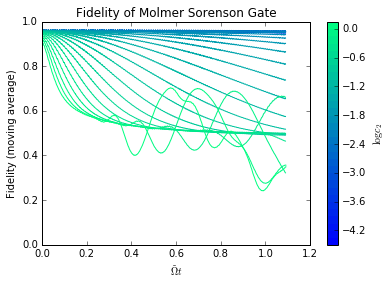

In [55]:
for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    rabi_energy_effective = -MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    t_plot = t[0:-window_size+1] * 2 *rabi_energy_effective
    
    
    
    
    signal =  moving_average(fidelity_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("Fidelity of Molmer Sorenson Gate")
plt.ylabel("Fidelity (moving average)")
plt.xlabel(r"$ \tilde{\Omega} t $")
CB = plt.colorbar(CS3)
CB.ax.set_ylabel(r"$\log c_2$")
plt.ylim(0, 1)
plt.savefig("MS_fidelity_cComparison.png")

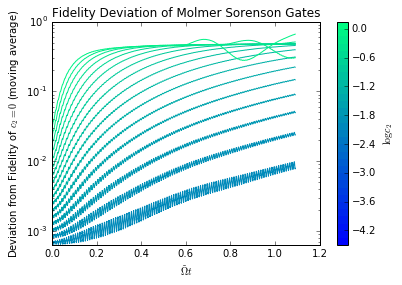

In [56]:
condon_fidelity = fidelity_signals[0]


for i, c_2 in enumerate(c_2_values):
    if i < 11:
        continue
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    rabi_energy_effective = -MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    t_plot = t[0:-window_size+1] * 2 *rabi_energy_effective
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    try:
        signal =  1 - moving_average(fidelity_signals[i] / condon_fidelity, window_size)
        plt.semilogy(t_plot, signal, label=label_scale[i], color = colorVal)
    except:
        continue
    
    

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("Fidelity Deviation of Molmer Sorenson Gates")
plt.ylabel(r"Deviation from Fidelity of $c_2=0$ (moving average)")
plt.xlabel(r"$ \tilde{\Omega} t $")
plt.ylim(10**-3.2, 1)
CB = plt.colorbar(CS3)
CB.ax.set_ylabel(r"$\log c_2$")
plt.savefig("MS_fidelityDeviation_cComparison.png")

0.0
0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


(0, 1)

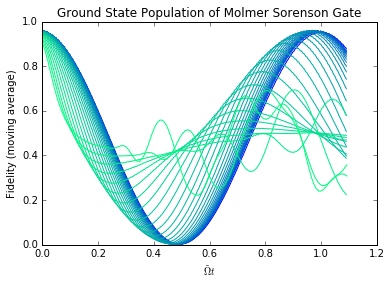

In [57]:
for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    rabi_energy_effective = -MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    t_plot = t[0:-window_size+1] * 2 *rabi_energy_effective
    
    signal =  moving_average(gg_population_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("Ground State Population of Molmer Sorenson Gate")
plt.ylabel("Fidelity (moving average)")
plt.xlabel(r"$ \tilde{\Omega} t $")
plt.savefig("MS_gg_population_cComparison.png")
plt.ylim(0, 1)

0.0
0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


(0, 1)

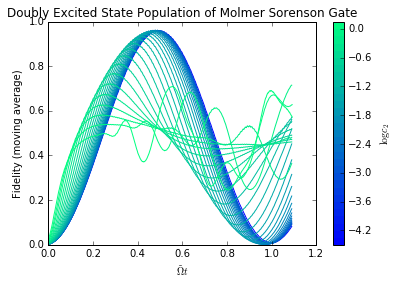

In [58]:
for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    rabi_energy_effective = -MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    t_plot = t[0:-window_size+1] * 2 *rabi_energy_effective
    
    signal =  moving_average(ee_population_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("Doubly Excited State Population of Molmer Sorenson Gate")
plt.ylabel("Fidelity (moving average)")
plt.xlabel(r"$ \tilde{\Omega} t $")
plt.savefig("MS_ee_population_cComparison.png")
CB = plt.colorbar(CS3)
CB.ax.set_ylabel(r"$\log c_2$")
plt.ylim(0, 1)

0.0
0.000316227766017
0.000388405806934
0.000477058269614
0.000585945391507
0.000719685673001
0.000883951773374
0.0010857111194
0.00133352143216
0.00163789370695
0.00201173804228
0.00247091122799
0.00303488931872
0.00372759372031
0.00457840582785
0.0056234132519
0.0069069404921
0.00848342898244
0.0104197462512
0.01279802214
0.0157191323806
0.0193069772888
0.0237137370566
0.0291263265491
0.0357743233898
0.0439397056076
0.0539688118723
0.0662870316183
0.0814168481448
0.1


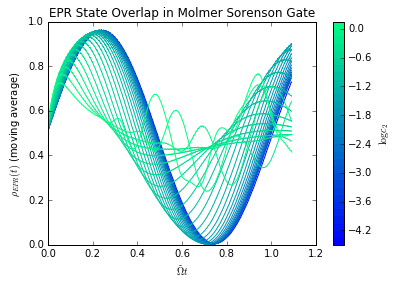

In [80]:
#EPR State Evolution
epr_wf = np.zeros(4, dtype = np.complex)
epr_wf[0] = 1.0
epr_wf[3] = -1.0j
epr_wf = epr_wf / math.sqrt(2.0)

for i, c_2 in enumerate(c_2_values):
    print(c_2)
    MS_system = results_storage[c_2]

    t = MS_system.time_values
    rabi_energy_effective = -MS_system.effective_rabi_energy(eta=eta, 
                                       laser_detuning = laser_detuning_delta_energy, 
                                       laser_rabi_energy = rabi_energy) 
    t_plot = t[0:-window_size+1] * 2 *rabi_energy_effective
    
    signal =  moving_average(epr_amplitude_signals[i], window_size)
    
    colorVal = scalarMap.to_rgba(colorbar_Scale[i])
    plt.plot(t_plot, signal, label=label_scale[i], color = colorVal)

# plt.legend(loc=0, fancybox=True, shadow=True, title=r"$\log \left(c_2\right)$")
plt.title("EPR State Overlap in Molmer Sorenson Gate")
plt.ylabel(r"$\rho_{EPR} (t)$ (moving average)")
plt.xlabel(r"$ \tilde{\Omega} t $")
CB = plt.colorbar(CS3)
CB.ax.set_ylabel(r"$\log c_2$")
plt.ylim(0, 1)
plt.savefig("MS_epr_overlap_cComparison.png")